In [1]:
import random
import time
import os

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt

Ref: Section 7 (Appendix) from CycleGAN

## Generator Architecture

In [2]:
# CINR = Convolution Instance Norm ReLU
# 3x3 convolutions with stride 1/2, 1 or 2 depending on position
# Uses reflection padding
# In the paper:
# dk denotes a k filter stride 2 with 3x3 conv
# c7s1-k denotes a k filter stride 1 with 7x7 conv
# uk denotes a k filter stride 1/2 with 3x3 conv
class GeneratorCINRLayer(nn.Module):
    def __init__(self, in_ch, out_ch, stride, kernel_size, reflect_pad):
        super().__init__()
        
        layers = []
        
        padding = 1
        
        if reflect_pad:
            layers.append(nn.ReflectionPad2d(kernel_size // 2))
            padding = 0

        if stride < 1:
          layers.append(
              nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=int(1 / stride), padding=padding, output_padding=padding, bias=True)
          )
        else:
          layers.append(
              nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
          )
        
        layers += [
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(True)
        ]
        
        self.seq = nn.Sequential(*layers)
    
    def forward(self, batch):
        return self.seq(batch)

In [3]:
# Contains 2 3x3 convolutional layers with the same number of filters on both layers
# Use reflect padding in these
# Don't use dropout
# Use instancenorm
class GeneratorResidualBlock(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True),
            nn.InstanceNorm2d(feature_size),
            nn.ReLU(True),
            # Dropout would go here if I want it
            nn.ReflectionPad2d(1),
            nn.Conv2d(feature_size, feature_size, kernel_size=3, bias=True)
        ]
        
        self.seq = nn.Sequential(*layers)
    
    def forward(self, batch):
        return batch + self.seq(batch)

In [4]:
# For the 128x128 case:
# c7s1-64, d128, d256, R256 x 6, u128, u64, c7s1-3
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers = [
            GeneratorCINRLayer(in_ch=3, out_ch=64, stride=1, kernel_size=7, reflect_pad=True),
            GeneratorCINRLayer(in_ch=64, out_ch=128, stride=2, kernel_size=3, reflect_pad=False),
            GeneratorCINRLayer(in_ch=128, out_ch=256, stride=2, kernel_size=3, reflect_pad=False),
            
            # same dim all the way through
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            GeneratorResidualBlock(feature_size=256),
            
            GeneratorCINRLayer(in_ch=256, out_ch=128, kernel_size=3, stride=0.5, reflect_pad=False),
            GeneratorCINRLayer(in_ch=128, out_ch=64, kernel_size=3, stride=0.5, reflect_pad=False),
            GeneratorCINRLayer(in_ch=64, out_ch=3, stride=1, kernel_size=7, reflect_pad=True),

            nn.Tanh()
        ]
        
        self.seq = nn.Sequential(*layers)
        
    def forward(self, batch):
        return self.seq(batch)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if (torch.cuda.device_count()>0):
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1080


In [ ]:
generator_model = Generator().to(device).eval()

In [ ]:
with torch.no_grad():
  summary(generator_model, input_size=(3, 128, 128))

TODO: Initialise the weights \\
TODO: PatchGAN \\
TODO: Put altogther into CycleGAN \\
TODO: Loss functions \\
TODO: Optimiser scheduler \\
TODO: History buffer \\
TODO: Generalise CINR layer to work for both discriminator and generator?

## PatchGAN

In [5]:
# CINR = Convolution Instance Normalisation Layer
# Denoted Ck where k = #filters
class DiscriminatorCINRLayer(nn.Module):
    def __init__(self, in_ch, out_ch, stride, apply_norm):
        super().__init__()

        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=stride, padding=1),
        ]

        if apply_norm:
            layers.append(
                # nn.BatchNorm2d(out_ch)
                nn.InstanceNorm2d(out_ch)
            )
        
        layers.append(
            nn.LeakyReLU(0.2)
        )

        self.seq = nn.Sequential(*layers)
    
    def forward(self, batch):
        return self.seq(batch)

In [6]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = [
            DiscriminatorCINRLayer(in_ch=3, out_ch=64, stride=2, apply_norm=False),
            DiscriminatorCINRLayer(in_ch=64, out_ch=128, stride=2, apply_norm=True),
            DiscriminatorCINRLayer(in_ch=128, out_ch=256, stride=2, apply_norm=True),
            DiscriminatorCINRLayer(in_ch=256, out_ch=512, stride=1, apply_norm=True),
            # In the source of CycleGAN they use k=4, s=1, p=1 despite not saying this in the paper
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.seq = nn.Sequential(*layers)

    def forward(self, batch):
        return self.seq(batch)

In [ ]:
discriminator_model = PatchDiscriminator()
discriminator_model.to(device).eval()

In [ ]:
with torch.no_grad():
    summary(discriminator_model, (3, 128, 128))

In [7]:
class HistoryBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        
    def __len__(self):
        return len(self.buffer)

    def _make_space(self, max_del_size):
        current_available_space = self.max_size - len(self)
        del_size = max(0, max_del_size - current_available_space)

        if del_size == 0:
            return

        del_indexes = random.sample(range(0, len(self)), del_size)

        for del_idx in del_indexes:
            del self.buffer[del_idx]

    def add(self, batch):
        self._make_space(len(batch))

        for item in batch:
            self.buffer.append(item.detach().cpu())

    def sample_batch(self, batch_size):
        return torch.stack(random.sample(self.buffer, batch_size))

    def randomise_existing_batch(self, existing_batch):
        if len(self) < existing_batch.shape[0] / 2:
            return existing_batch
        
        new_batch = []

        for item in existing_batch:
            if random.uniform(0, 1) < 0.5:
                new_batch.append(item.detach().cpu())
            else:
                new_batch.append(self.buffer[random.randint(0, len(self) - 1)])

        return torch.stack(new_batch)

In [43]:
class CycleGAN:
    def __init__(self, root_dir, device):
        self.G = Generator().to(device) # Maps X -> Y
        self.D_X = PatchDiscriminator().to(device) # Takes input from 'X' and predicts if it is real or not

        self.F = Generator().to(device) # Maps Y -> X
        self.D_Y = PatchDiscriminator().to(device) # Takes input from 'Y' and predicts if it is real or not

        # Depending on shading output, we may need to apply L_identity
        # See section 5.2 -> Photo generation from paintings

        # GAN mode = lsgan

        self.G_opt = optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.D_X_opt = optim.Adam(self.D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.F_opt = optim.Adam(self.F.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.D_Y_opt = optim.Adam(self.D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self.gan_X_loss = nn.MSELoss().to(device)
        self.gan_Y_loss = nn.MSELoss().to(device)

        self.cycle_X_loss = nn.L1Loss().to(device)
        self.cycle_Y_loss = nn.L1Loss().to(device)

        self.fake_X_buffer = HistoryBuffer(50)
        self.fake_Y_buffer = HistoryBuffer(50)
        
        self.root_dir = root_dir
        self.created_at = time.time()
        
    def set_discriminator_gradients(self, enabled):
        for parameter in self.D_X.parameters():
            parameter.requires_grad = enabled
        
        for parameter in self.D_Y.parameters():
            parameter.requires_grad = enabled
    
    def set_generator_gradients(self, enabled):
        for parameter in self.G.parameters():
            parameter.requires_grad = enabled
        
        for parameter in self.F.parameters():
            parameter.requires_grad = enabled
            
    def save(self, epoch):
        folder = f"{self.root_dir}/{self.created_at}/{epoch}"
        os.makedirs(folder, exist_ok=True)
        
        torch.save({
            "epoch": epoch,
            "G_state": self.G.state_dict(),
            "D_X_state": self.D_X.state_dict(),
            "F_state": self.F.state_dict(),
            "D_Y_state": self.D_Y.state_dict(),
            "G_opt_state": self.G_opt.state_dict(),
            "D_X_opt_state": self.G_opt.state_dict(),
            "F_opt_state": self.G_opt.state_dict(),
            "D_Y_opt_state": self.G_opt.state_dict(),
            "fake_max_size": 50,
            "fake_X_buffer": self.fake_X_buffer.buffer,
            "fake_Y_buffer": self.fake_Y_buffer.buffer
        }, f"{folder}/checkpoint.pth")
        
        torch.save(self.G.state_dict(), f"{folder}/G_network.model")        
        torch.save(self.F.state_dict(), f"{folder}/F_network.model")
        

1. Translate real images from X to Y and then back again from Y to X (call these fake_Y, cycled_X)
2. Translate real images from Y to X and then back again from X to Y (call these fake_X, cycled_Y)
3. Disable gradients on discriminators, then backprop and optimise the generators
4. Disable gradients on generators (re-enable on dis!), then backprop and optimise the discriminators

In [44]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.data = []
        
        tensor_transform = transforms.ToTensor()
        
        for file_name in os.listdir(folder):
            img = Image.open(f"{folder}/{file_name}").convert("RGB")
            tensored = tensor_transform(img)
            self.data.append(tensored)
            
        self.real_length = len(self.data)
        self.forced_length = len(self.data)
    
    def __getitem__(self, index):
        # May be better to randomise if index > self.real_length ?
        return self.data[index % self.real_length]
    
    def __len__(self):
        return self.forced_length

In [45]:
batch_size = 1
epochs = 100
cyclegan = CycleGAN("./runs", device)

In [46]:
X_dataset = ImageDataset("./cyclegan_original_data/horse2zebra/trainA")

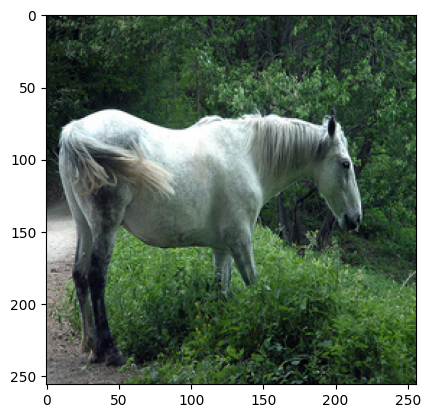

In [47]:
plt.imshow(X_dataset.data[random.randint(0, len(X_dataset))].permute(1, 2, 0))

In [48]:
Y_dataset = ImageDataset("./cyclegan_original_data/horse2zebra/trainB")

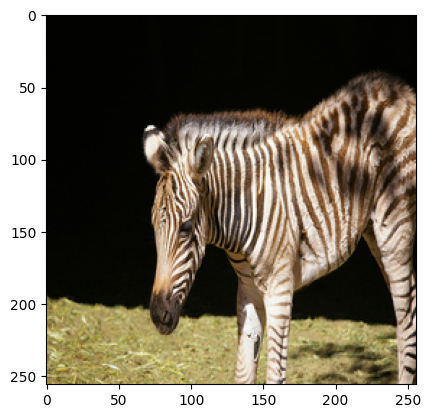

In [49]:
plt.imshow(Y_dataset.data[random.randint(0, len(Y_dataset))].permute(1, 2, 0))

In [50]:
print("X pre", len(X_dataset))
print("Y pre", len(Y_dataset))

required_length = max(len(X_dataset), len(Y_dataset))

X_dataset.forced_length = required_length
Y_dataset.forced_length = required_length

print("X aft", len(X_dataset))
print("Y aft", len(Y_dataset))

X_dataloader = torch.utils.data.DataLoader(X_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
Y_dataloader = torch.utils.data.DataLoader(Y_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

X pre 1067
Y pre 1334
X aft 1334
Y aft 1334


In [52]:
lambda_weight = 10

for epoch in range(epochs):
    batch_start_time = time.time()
    epoch_start_time = time.time()
    
    for batch_no, (org_x, org_y) in enumerate(zip(X_dataloader, Y_dataloader), 0):
        org_x = org_x.to(device)
        org_y = org_y.to(device)
        
        # 1. Translate org_x to fake_y and then fake_y to cycled_x
        # print(org_x.shape)
        fake_y = cyclegan.G(org_x)
        cycled_x = cyclegan.F(fake_y)
        
        # 2. Translate org_y to fake_x and then fake_x to cycled_y
        # print(org_y.shape)
        fake_x = cyclegan.F(org_y)
        cycled_y = cyclegan.G(fake_x)
        
        # 3. Disable gradients on the discriminators, then backprop and optimise the gradients
        cyclegan.set_discriminator_gradients(False)
        # cyclegan.set_generator_gradients(True)
        
        cyclegan.G_opt.zero_grad()
        cyclegan.F_opt.zero_grad()
        
        # Do the fake images fool the GAN, if so the generator is performing well
        G_fool_loss = cyclegan.gan_X_loss(fake_x, torch.ones_like(fake_x))
        F_fool_loss = cyclegan.gan_Y_loss(fake_y, torch.ones_like(fake_y))
        
        # Do the X -> Y -> X images look like they belong in X (and Y etc)
        G_cycle_loss = cyclegan.cycle_X_loss(cycled_x, org_x)
        F_cycle_loss = cyclegan.cycle_Y_loss(cycled_y, org_y)
        
        generator_loss = G_fool_loss + lambda_weight * G_fool_loss + F_fool_loss + lambda_weight * F_fool_loss
        generator_loss.backward()
        
        cyclegan.G_opt.step()
        cyclegan.F_opt.step()
        
        # 4. Disable gradients on the generators, then backprop and optimise the gradients
        cyclegan.set_discriminator_gradients(True)
        # cyclegan.set_generator_gradients(False) do we ever need to turn off the generator gradients?
        
        cyclegan.D_X_opt.zero_grad()
        cyclegan.D_Y_opt.zero_grad()
        
        real_pred_X = cyclegan.D_X(org_x)
        D_X_real_loss = cyclegan.gan_X_loss(real_pred_X, torch.ones_like(real_pred_X))
        # Use the history of fakes
        rand_fake_X = cyclegan.fake_X_buffer.randomise_existing_batch(fake_x).to(device)
        fake_pred_X = cyclegan.D_X(rand_fake_X.detach())
        D_X_fake_loss = cyclegan.gan_X_loss(fake_pred_X, torch.zeros_like(fake_pred_X))
        D_X_loss = (D_X_real_loss + D_X_fake_loss) / 2
        
        real_pred_Y = cyclegan.D_X(org_y)
        D_Y_real_loss = cyclegan.gan_X_loss(real_pred_Y, torch.ones_like(real_pred_Y))
        # Use the history of fakes
        rand_fake_Y = cyclegan.fake_Y_buffer.randomise_existing_batch(fake_y).to(device)
        fake_pred_Y = cyclegan.D_X(rand_fake_Y.detach())
        D_Y_fake_loss = cyclegan.gan_Y_loss(fake_pred_Y, torch.zeros_like(fake_pred_Y))
        D_Y_loss = (D_Y_real_loss + D_Y_fake_loss) / 2
        
        D_Y_loss.backward()
        D_X_loss.backward()
        
        cyclegan.D_X_opt.step()
        cyclegan.D_Y_opt.step()
        
        # Add to the history buffer
        cyclegan.fake_X_buffer.add(fake_x)
        cyclegan.fake_Y_buffer.add(fake_y)
        
        if batch_no % 5 == 0 and batch_no != 0: 
            duration = time.time() - batch_start_time
            print(f"[{epoch}:{batch_no}] Took {duration:.2f}s")
            batch_start_time = time.time()
    
    print(f"[{epoch}:END] Completed epoch in {time.time() - epoch_start_time}")
    
    if epoch % 5 == 0 and epoch != 0:
        print(f"[{epoch}:END] Saving models and training information")
        cyclegan.save(epoch)

[0:5] Took 1.09s
[0:10] Took 0.89s
[0:15] Took 0.85s
[0:20] Took 0.84s
[0:25] Took 0.84s


KeyboardInterrupt: 